# FITC and VFE

The most general Gaussian Process approximation methods are FITC (fully independent training conditional), and VFE (variational free energy).  These GP approximations don't form the full covariance matrix over all $n$ training inputs.  Instead they rely on $m < n$ *inducing points*, which are "strategically" placed throughout the domain.  Both of these approximations reduce the $\mathcal{O(n^3)}$ complexity of GPs down to $\mathcal{O(nm^2)}$ --- a significant speed up.  They are commonly referred to as *sparse* approximations, in the sense of being data sparse.  The downside of sparse approximations is that they reduce the expressiveness of the GP.  Reducing the dimension of the covariance matrix effectively reduces the number of covariance matrix eigenvectors that can be used to fit the data.

## FITC 

The FITC approximation is generally considered the "gold-standard" GP approximation.  It was originally called sparse Gaussian Processes using pseudo-inputs (SGPP) [Snelson+Ghahramani, 2006].  It was reformulated by [Quinonero-Candela+Rasmussen, 2006].  Therein, they showed that the FITC approximation can be thought of as not just an approximation, but also as sort of an odd Gaussian Process prior in its own right,

$$
f \sim \mathcal{GP}_{FITC}(0\,, Q_{ff} - \mathrm{diag}[K_{ff} - Q_{ff}]) \,.
$$

The matrix $Q_{ff}$ is the Nystrom approximation to the full covariance matrix, $K_{ff}$.

$$
Q_{ff} = K_{fu}K_{uu}^{-1}K_{uf}
$$

## VFE

The VFE approximation is a bit newer [Titsias 2009], and is derived from a variational approach.  The marginal likelihood is derived by trying to minimize the Kullback-Leibler divergence between the sparse GP and the full GP.  It uses a variational formulation to obtain a lower bound on the marginal likelihood.  

## Comparison

Currently, both of these methods can only be applied to Gaussian Process models with IID Gaussian noise:

$$
\begin{aligned}
y \sim N(f\,, \sigma^2 \mathbf{I})& \\
f \sim \mathcal{GP}(\mu(x)\,, k(x, x'))&\\
\end{aligned}
$$

I'm positive VFE can only be used in this scenario.  I'm not completely convinced that FITC cannot be used with Gaussian noise that has correlations.   Neither method is intended to be used with non-Gaussian likelihoods.  Interestingly, both methods have a similar form for the marginal likelihood:

$$
-\mathcal{L} = \frac{n}{2}\log(2\pi) + \frac{1}{2} \log|Q_{ff} + G| +
               \frac{1}{2}y^T(Q_{ff} + G)^{-1}y + 
               \frac{1}{2\sigma_n^2}tr(T)
$$
where $G_{FITC} = \mathrm{diag}[K_{ff} - Q_{ff}] + \sigma^2_n I$, and $G_{VFE} = \sigma^2_n I$.  Also, 
$T_{VFE} = K_{ff} - Q_{ff}$, while $T_{FITC} = 0$.  Because of this similarity, I implemented 
both methods in PyMC3 with a flag to use either approximation.  I plan on Latex'ing this up and posting it soon, it took some time to work out! 

# Examples

## 1 Dimensional Data, 50 data points

In [1]:
import pymc3 as pm
import GPflow

import theano
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(101)

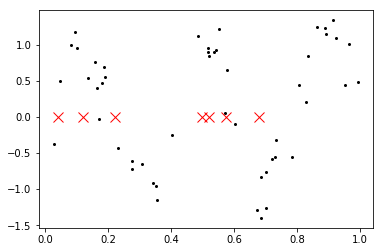

In [2]:
nx, nu = 50, 7
x = np.random.rand(nx)
xu = np.random.rand(nu)
y = np.sin(2 * np.pi * x * 2.5) + 0.3 * np.random.randn(nx)
    
plt.plot(x, y, 'ko', ms=2);
plt.plot(xu, 0.0*np.ones(len(xu)), 'rx', ms=10)
x = x[:,None]; xu = xu[:,None]
xs = np.linspace(-0.1, 1.1, 100)

## Full GP 

I set reasonable `testval`'s on all the hyperparameter priors.  I found this makes I huge difference with the GP models at the inference step.  I plan on looking into why this is and the effects on NUTS and ADVI.  

### Inference

In [3]:
with pm.Model() as model:
    ℓ = pm.HalfCauchy("ℓ", beta=5, testval=0.1)
    σ2_n = pm.HalfCauchy("σ2_n", beta=5, testval=0.1)
    σ2_f = pm.HalfCauchy("σ2_f", beta=5, testval=1.0)
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.GPFullConjugate("gp", X=x, cov_func=cov, sigma2=σ2_n, observed=y)
    trace = pm.fit(10000, method='advi').sample(1000, True)

Average Loss = 37.188: 100%|██████████| 10000/10000 [00:21<00:00, 466.47it/s]
Finished [100%]: Average Loss = 37.184


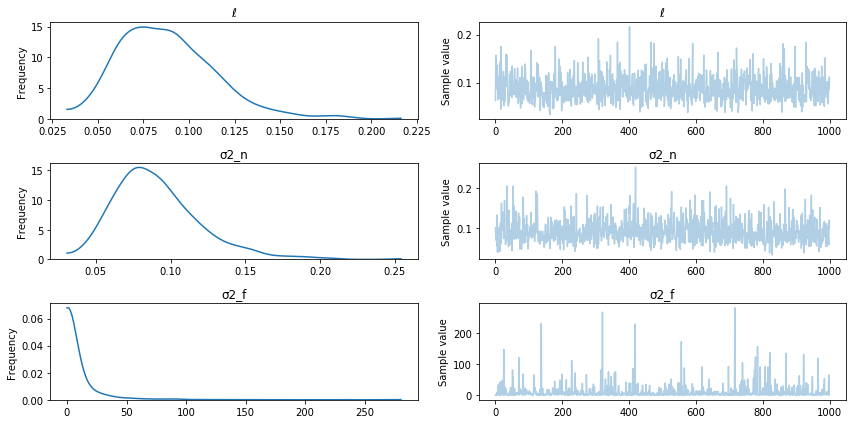

In [4]:
pm.traceplot(trace);

### Posterior sampling

100%|██████████| 100/100 [00:49<00:00,  2.08it/s]


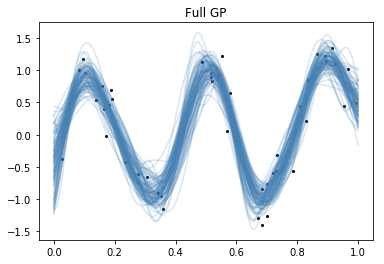

In [5]:
xs = np.linspace(0,1,100)[:,None]
with model:
    samples = pm.gp.sample_gp(trace[:100], gp, X_values=xs, obs_noise=False)
    
plt.plot(x.flatten(), y, 'ko', ms=2);
plt.plot(xs.flatten(), samples.T, "steelblue", alpha=0.2);
plt.title("Full GP");

## FITC

The only difference in the API is the required `inducing_points` and `approx` arguments. 

### Inference

In [6]:
with pm.Model() as model:
    ℓ = pm.HalfCauchy("ℓ", beta=5, testval=0.1)
    σ2_n = pm.HalfCauchy("σ2_n", beta=5, testval=0.1)
    σ2_f = pm.HalfCauchy("σ2_f", beta=5, testval=1.0)
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.GPSparseConjugate("gp", approx="fitc", X=x, inducing_points=xu, 
                                 cov_func=cov, sigma2=σ2_n, observed=y)
    trace = pm.fit(10000, method='advi').sample(1000, True)

Average Loss = 48.815: 100%|██████████| 10000/10000 [00:14<00:00, 670.32it/s]
Finished [100%]: Average Loss = 48.809


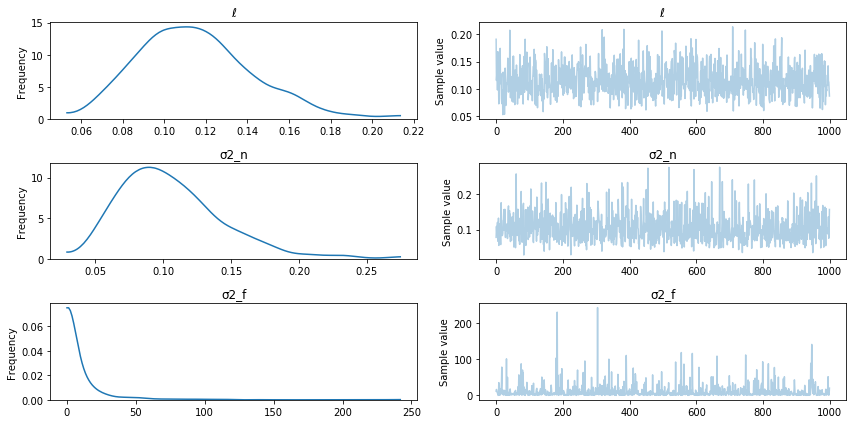

In [7]:
pm.traceplot(trace);

### Posterior sampling

100%|██████████| 100/100 [01:28<00:00,  1.18it/s]


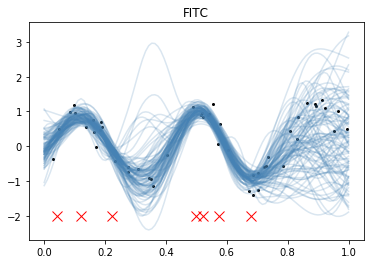

In [8]:
xs = np.linspace(0,1,100)[:,None]
with model:
    samples = pm.gp.sample_gp(trace[:100], gp, X_values=xs, obs_noise=False)
    
plt.plot(x.flatten(), y, 'ko', ms=2);
plt.plot(xu.flatten(), -2 * np.ones(len(xu)), "rx", ms=10)
plt.plot(xs.flatten(), samples.T, "steelblue", alpha=0.2);
plt.title("FITC");

It is apparent in the GP predictive distribution how sparse approximations resemble the GP less in regions where there aren't inducing points (which are shown with red "x"s).  Here the predictions go towards the FITC prior.  FITC is also known to underestimate the noise variance, see the trace plot.


## VFE

Notice that `approx` has been set to `"vfe"`.

### Inference

In [9]:
with pm.Model() as model:
    ℓ = pm.HalfCauchy("ℓ", beta=5, testval=0.1)
    σ2_n = pm.HalfCauchy("σ2_n", beta=5, testval=0.1)
    σ2_f = pm.HalfCauchy("σ2_f", beta=5, testval=1.0)
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.GPSparseConjugate("gp", approx="vfe", X=x, inducing_points=xu, 
                                 cov_func=cov, sigma2=σ2_n, observed=y)
    trace = pm.fit(10000, method='advi').sample(1000, True)

Average Loss = 64.288: 100%|██████████| 10000/10000 [00:13<00:00, 733.51it/s]
Finished [100%]: Average Loss = 64.285


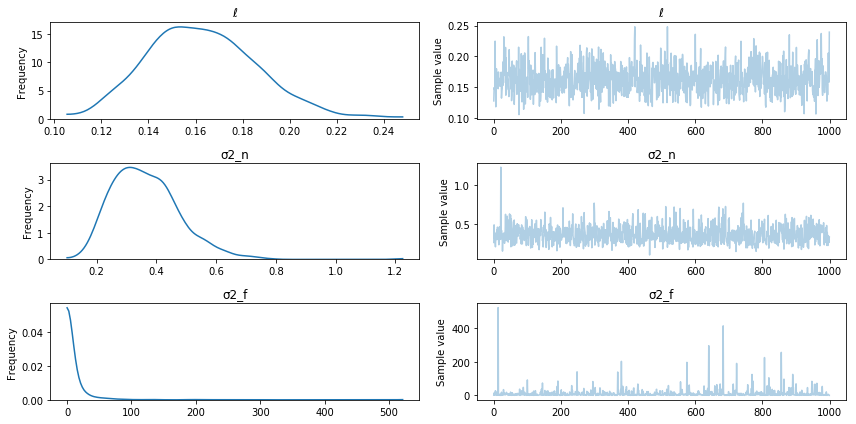

In [10]:
pm.traceplot(trace);

### Posterior sampling

100%|██████████| 100/100 [01:15<00:00,  1.44it/s]


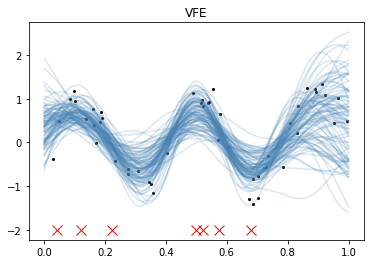

In [11]:
xs = np.linspace(0,1,100)[:,None]
with model:
    samples = pm.gp.sample_gp(trace[:100], gp, X_values=xs, obs_noise=False)
    
plt.plot(x.flatten(), y, 'ko', ms=2);
plt.plot(xu.flatten(), -2 * np.ones(len(xu)), "rx", ms=10)
plt.plot(xs.flatten(), samples.T, "steelblue", alpha=0.2);
plt.title("VFE");

See how VFE doesn't underestimate the noise variance in this case.  Also, the trace term in the marginal likelihood penalizes large variances in the diagonal of the covariance matrix.  This helps keep the GP predictions tighter in regions where there are few inducing point.  Notice how in these regions there is less variation in the VFE predictions than in FITC.   

# More data, n = 10000

50 data points really isn't very much.  Estimating the posterior on the full GP didn't take that much longer than it did with VFE or FITC.  Note that ADVI is slower than minimizing the marginal likelihood with L-BFGS-B or similar, which is what most GP software packages rely on.  This is why PyMC3 might feel slower than GPflow or scikit-learn.  To show off the speedup, we run FITC and VFE with the same 7 inducing inputs but now with 10000 data points.  The full GP for this amount of data is way too slow to do in any reasonable amount of time.

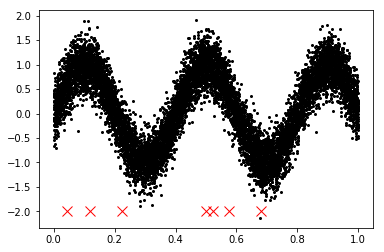

In [12]:
nx = 10000
x = np.random.rand(nx)
y = np.sin(2 * np.pi * x * 2.5) + 0.3 * np.random.randn(nx)
    
plt.plot(x, y, 'ko', ms=2);
plt.plot(xu, -2*np.ones(len(xu)), 'rx', ms=10)
x = x[:,None]

## FITC


### Inference

In [13]:
with pm.Model() as model:
    ℓ = pm.HalfCauchy("ℓ", beta=5, testval=0.1)
    σ2_n = pm.HalfCauchy("σ2_n", beta=5, testval=0.1)
    σ2_f = pm.HalfCauchy("σ2_f", beta=5, testval=1.0)
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.GPSparseConjugate("gp", approx="fitc", X=x, inducing_points=xu, 
                                 cov_func=cov, sigma2=σ2_n, observed=y)
    trace = pm.fit(10000, method='advi').sample(1000, True)

Average Loss = 3,770: 100%|██████████| 10000/10000 [01:37<00:00, 102.08it/s] 
Finished [100%]: Average Loss = 3,769.3


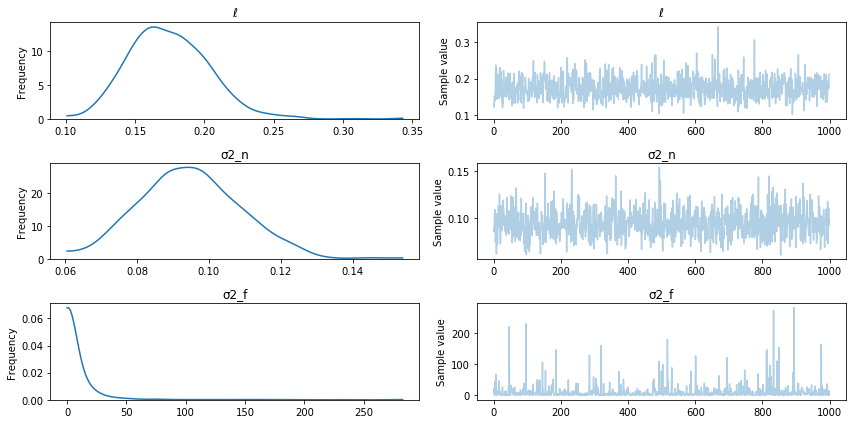

In [14]:
pm.traceplot(trace);

### Posterior sampling

100%|██████████| 100/100 [01:26<00:00,  1.34it/s]


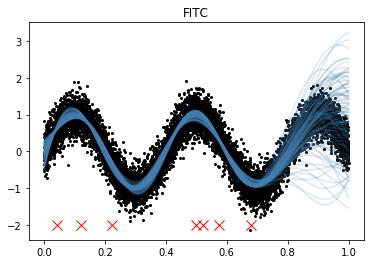

In [15]:
xs = np.linspace(0,1,100)[:,None]
with model:
    samples = pm.gp.sample_gp(trace[:100], gp, X_values=xs, obs_noise=False)
    
plt.plot(x.flatten(), y, 'ko', ms=2);
plt.plot(xu.flatten(), -2 * np.ones(len(xu)), "rx", ms=10)
plt.plot(xs.flatten(), samples.T, "steelblue", alpha=0.2);
plt.title("FITC");

## VFE

### Inference

In [16]:
with pm.Model() as model:
    ℓ = pm.HalfCauchy("ℓ", beta=5, testval=0.1)
    σ2_n = pm.HalfCauchy("σ2_n", beta=5, testval=0.1)
    σ2_f = pm.HalfCauchy("σ2_f", beta=5, testval=1.0)
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.GPSparseConjugate("gp", approx="vfe", X=x, inducing_points=xu, 
                                 cov_func=cov, sigma2=σ2_n, observed=y)
    trace = pm.fit(10000, method='advi').sample(1000, True)

Average Loss = 5,991.7: 100%|██████████| 10000/10000 [01:27<00:00, 114.05it/s]
Finished [100%]: Average Loss = 5,994.9


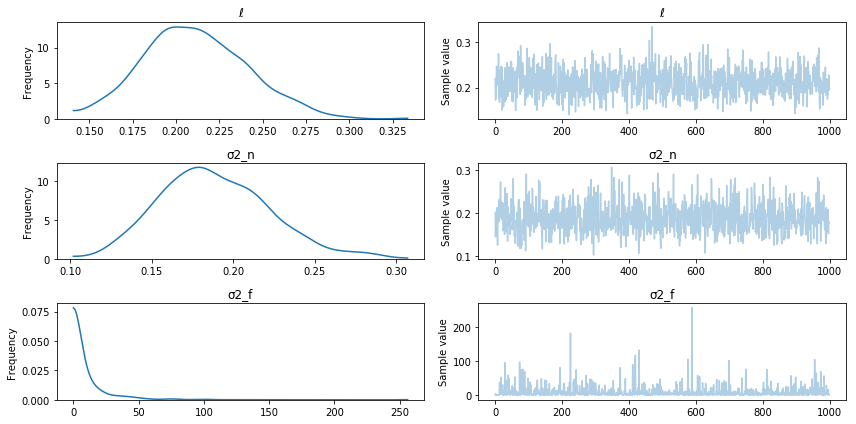

In [17]:
pm.traceplot(trace);

### Posterior sampling

100%|██████████| 100/100 [01:19<00:00,  1.44it/s]


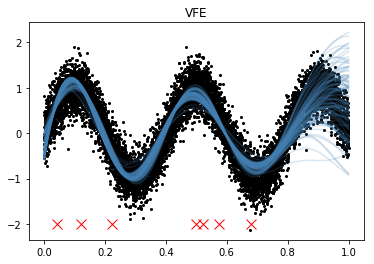

In [18]:
xs = np.linspace(0,1,100)[:,None]
with model:
    samples = pm.gp.sample_gp(trace[:100], gp, X_values=xs, obs_noise=False)
    
plt.plot(x.flatten(), y, 'ko', ms=2);
plt.plot(xu.flatten(), -2 * np.ones(len(xu)), "rx", ms=10)
plt.plot(xs.flatten(), samples.T, "steelblue", alpha=0.2);
plt.title("VFE");

# Next Time

- implementation steps
- optimizing inducing point locations
- timing tests
- comparison to other GP libraries